# Exercise 10-1: Non-linear classification by means of a non-linear map

In the following we adapt the SoftMaxAdaline to include a non-linear map

$\Phi\left((x_1, x_2)\right)=(x_1, x_2, x_1^2+x_2^2)$

and apply the resulting classifier to the Iris training data (pedal length, pedal width) and label classes (setosa, versicolor, virginica).

The only changes are in the definition of the soft-max Adaline class that allow to specify a map like the above $\Phi$ to be applied to the input features. This map is defined in the cell defining also the initial model parameters.

**NOTE:** The behavior you see will depend crucially on the random seed that is used to generate the random numbers for the shuffling of the data. Depending on the choice of training data, you might have to adapt the learning rates in order to see the expected behavior for "too small" and "too large" values. There are two possibilities to get reproduceable results:
* Fix the random seed for Numpy [random.seed()](https://numpy.org/doc/stable/reference/random/generated/numpy.random.seed.html?highlight=seed#numpy.random.seed)
* Use the entire data as training data (the distinction between test and training data will become relevant when we look at cross-validateion techniques)

In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

# For the animation feature we need another module of Matplotlib
import matplotlib.animation as animation
# as well as an IPython library to display the animation as HTML element
from IPython.display import HTML

%matplotlib inline
%config InlineBackend.figure_format='svg'

## Data preparation

We load the Iris data set from:

https://archive.ics.uci.edu/ml/datasets/iris

Since this data set has become the machine learning "Hello, World!"
equivalent, it is also part of many machine learning libraries. Have a look
at the Python module  `sklearn` submodule `datasets`, for example, which was
used
[here](https://gitlab.com/dirk-deckert-lmu/maml-ss20/-/blob/master/material/lec01/iris_plot.py)
to geenrate the Iris plot for the lecture notes.

Note that the column names are missing in the CSV file. They are described in
the accompanying file
https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.names.

In [2]:
file_name = 'iris_data_set.csv'
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
column_names = ['sepal length [cm]', 'sepal width [cm]',
                'petal length [cm]', 'petal width [cm]', 'iris type']

if os.path.exists(file_name):
    print(f'Loading data from local file `{file_name}`...')
    df = pd.read_csv(file_name)
else:
    print(f'Loading data from `{url}`...')
    df = pd.read_csv(url, names=column_names)
    df.to_csv(file_name)
    print('Done.')

Loading data from `https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data`...
Done.


**NOTE:** The Iris data set features three distinct labels, which we call 0, 1, and 2.

In [3]:
CLASS_LABEL_VALUES = [0, 1, 2]

df['class'] = df['iris type'].replace(
    ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'],
    CLASS_LABEL_VALUES)

# view the table
df

sepal length [cm]  sepal width [cm]  ...       iris type  class
0                  5.1               3.5  ...     Iris-setosa      0
1                  4.9               3.0  ...     Iris-setosa      0
2                  4.7               3.2  ...     Iris-setosa      0
3                  4.6               3.1  ...     Iris-setosa      0
4                  5.0               3.6  ...     Iris-setosa      0
..                 ...               ...  ...             ...    ...
145                6.7               3.0  ...  Iris-virginica      2
146                6.3               2.5  ...  Iris-virginica      2
147                6.5               3.0  ...  Iris-virginica      2
148                6.2               3.4  ...  Iris-virginica      2
149                5.9               3.0  ...  Iris-virginica      2

[150 rows x 6 columns]

and furthermore, shuffle the data:

In [4]:
def shuffle_df(df, training_data_fraction, random_state=None):
    '''
    Split all available data into a training and test data set.
    
    Parameters
    -----------
    df : DataFrame
        DataFrame of available data.
    training_data_fraction : float
        The fraction of the data that should be used for training.
        E.g., `training_data_fraction=0.6` means 60%.
    random_state : int or numpy.random.RandomState, optional
        Allows to fix the seed for the pseudo-random numbers, 
        which is helpful for debugging in order to reproduce results.
        
    Returns
    -------
    Tuple of lists for test and training data.    
    '''
    # first, we use the `sample()` function to select a fraction of the data
    # frame for the training data
    train_df = df.sample(frac=training_data_fraction, 
                         random_state=random_state)
    # second, we use the index of the just defined training data in the
    # function `drop()` that drops the respective entries from the data frame,
    # thus, leaving only the rest of the entries for our test data
    test_df = df.drop(train_df.index)
    return train_df, test_df

**NOTE:** It will be convenient to already substitude the class labels 1,2,3 by the respective unit vectors as we did in the lecture. Note the two new lines marked by comment `# substitude by unit vectors`.

In [5]:
training_data_fraction = .8

train_df, test_df = shuffle_df(df, training_data_fraction)

# translation table for the mapping of class labels to unit vectors
unit_vectors = [
    [[1.0], [0.0], [0.0]],
    [[0.0], [1.0], [0.0]],
    [[0.0], [0.0], [1.0]]
]

# convert DataFrame entries to Numpy arrays
# `train_X, train_Y`: training data
# `test_X, test_Y`: training data

train_X = train_df[['petal length [cm]', 'petal width [cm]']].to_numpy().reshape(len(train_df), 2, 1)
train_C = train_df['class'].to_numpy()
# substitude by unit vectors
train_Y = np.array([unit_vectors[l] for l in train_C])

test_X = test_df[['petal length [cm]', 'petal width [cm]']].to_numpy().reshape(len(test_df), 2, 1)
test_C = test_df['class'].to_numpy()
# substitude by unit vectors
test_Y = np.array([unit_vectors[l] for l in test_C])

print('Training data split as follows:')
print(f'  Training data samples: {len(train_df)}')
print(f'      Test data samples: {len(test_df)}')

Training data split as follows:
  Training data samples: 120
      Test data samples: 30


### Plotting function

**NOTE:** Since the class labels have changed we had to adapt our plotting function, too.

In [6]:
def plot_iris_decision_regions(model):
    '''
    Plot decision regions and test and training data for class labels `CLASS_LABEL_1`, `CLASS_LABEL_2`.
    
    Parameters
    ----------
    model : classifier model class
    '''

    # compute how large the mesh for the contour plot shall be (with +/- 1 as
    # safety bleed)
    x1_min = train_X[:, 0].min() - 1
    x1_max = train_X[:, 0].max() + 1
    x2_min = train_X[:, 1].min() - 1
    x2_max = train_X[:, 1].max() + 1

    # compute grid for contour plot
    x1_list, x2_list = np.meshgrid(np.arange(x1_min, x1_max, .01), 
                                np.arange(x2_min, x2_max, .01))
    # meshgrid produces two arrays of the size `len(np.arange(x1_min, x1_max,
    # .01))` times `len(np.arange(x2_min, x2_max, .01))` so that computations can
    # be easily be vectorized.  As our hypothesis expects a list of (2,1) vector we
    # reshape this array
    X_list = np.dstack([x1_list, x2_list]).reshape(*x1_list.shape, 2, 1)
    # present it our hypothesis for evaluation and reshape it to have the desired
    # form as expected by the contour plot.
    h_list = model.h(X_list).reshape(x1_list.shape)
    
    # this time we have three labels
    labels = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
    colors = ['red', 'blue', 'green']

    # In order to make the countour plot use all label values 
    # (which might not be generated by `model.h()` depending on the model parameters)
    # we set three class labels by hand in the (invisible) corners of the grid.
    # This enforces `plt.countourf()` to interpolate between all three colors.
    h_list[0, 0] = 0
    h_list[-1, 0] = 1
    h_list[-1, -1] = 2

    # plot decision regions
    cmap = matplotlib.colors.ListedColormap(colors)
    plt.contourf(x1_list, x2_list, h_list, cmap=cmap, alpha=.3)

    # plot training data
    for i in range(len(CLASS_LABEL_VALUES)):        
        train_X_class = train_X[train_C == CLASS_LABEL_VALUES[i]]
        plt.scatter(train_X_class[:, 0], train_X_class[:, 1], marker='x', color=colors[i], label=labels[i], alpha=.7)
        
    # plot test data
    for i in range(len(CLASS_LABEL_VALUES)):
        test_X_class = test_X[test_C == CLASS_LABEL_VALUES[i]]
        plt.scatter(test_X_class[:, 0], test_X_class[:, 1], marker='.', color=colors[i], label='Test: ' + labels[i], alpha=.7)

    plt.xlabel('sepal width [cm]')
    plt.xlim(x1_min, x1_max)
    plt.ylabel('sepal length [cm]')
    plt.ylim(x2_min, x2_max)
    plt.legend()

## Definition of the soft-max Adaline model

The soft-max activation function for $j=1,\ldots,m$:
* $\alpha_j(z)=\frac{e^{z_j}}{\sum_{i=1}^m e^{z_i}}$

In [11]:
class activation_softmax:
    
    @staticmethod
    def eval(Z):
        e = np.exp(Z)
        n = e.sum(axis=-2)
        return e / n.reshape([*n.shape, 1])
    
    # note that the derivative will not be needed as we will compute the 
    # total differential of L to exploit the cancellations

The cross-entropy loss for multi-class classification

$L(y,y')=-\sum_{j=1}^m y_j\log y'_j$

In [7]:
class loss_cross_entropy:
    
    @staticmethod
    def eval(Y, Z):
        # note the summation over the class vector components in comparison 
        # to the binary classification example
        return - (Y * np.log(Z)).sum(axis=1)

    # note that this is not the partial but the total derivative of L
    # which allows us to exploit the cancellations due to the derivative 
    # of alpha

This is an adaption of our soft-max Adaline with cross-entropy loss that we have inmplemented earlier.

The only difference is that we expect an addition function `phi` that is applied to the input features before further processing.

In [8]:
class NLSoftMaxAdaline:
    
    def __init__(self, w, b, eta, phi):
        '''
        Initializes the model parameters.

        Parameters
        ----------
        w : Array
            Array of the weight matrix of 
              dimension = (number of class labels) x (feature space dimensions).
        b : Array
            Array of the bias vector of 
              dimension = (number of class labels).
        eta : float
              Learning rate.
        '''
        self._w = w
        self._b = b
        self._eta = eta
        # feature space dimension
        self._n = w.shape[1]
        # class label space dimension
        self._m = w.shape[0]
        assert(self._m == b.shape[0])
        
        self._phi = phi
        
    def h(self, X):
        '''
        Evaluates the hypothesis corresponding to the given model parameters.

        Parameters
        ----------
        X : Array
            Array of the bias vector of 
              dimension = (feature space dimensions).
            
        Returns
        -------
        Array of evaluations having class labels taken values in {0, 1, 2, ..., (number of class labels - 1)}.

        '''
        activation_input = self._w @ self._phi(X) + self._b
        activation_output = activation_softmax.eval(activation_input)
        # This time we want to return the argmax of the activation output
        amax = np.argmax(activation_output, axis=-2)
        return amax
    
    def train(self, batch_X, batch_Y, epochs=1, mini_batches=1, verbose=False):
        '''
        Executes the update rule for a certain number of epochs and adapts the internal
        model parameters to the Adaline update rule.

        Parameters
        ----------
        bacth_X : Array
            Array of feature vectors.
        batch_Y : Array
            Array of class label vectors.
        epochs : int (optional)
            Number of epochs to train.
        verbose : bool
            True to print progress messages.

        Returns
        -------
        Tuple of lists of number of errors and loss.
        '''
        
        # map the features through phi
        phi_batch_X = self._phi(batch_X)
        
        loss_list = []
        err_list = []
        for e in range(epochs):
            
            # in order to shuffle the data we create a permutation of indices
            perm = np.random.permutation(len(batch_X))
            # and split this list of indices into mini batches of `batch_size`
            perm_list = np.array_split(perm, mini_batches)
            
            # carry out the update over the mini batches
            loss = 0
            errors = 0
            for p in perm_list:
                
                # select the features and labels of the permutation `p`
                X = phi_batch_X[p]
                Y = batch_Y[p]
                
                # As in the binary examples we compute the activation input and output.
                # Note however, that also in form similar, the dimensions of those arrays
                # are of course different now:
                activation_input = self._w @ X + self._b
                activation_output = activation_softmax.eval(activation_input)

                # As computed in the Exercise 08-3, we compute the differentials
                # for the bias and weight updates. Again noting the differences in
                # the dimensions of the arrays as compared to the binary clasification examples.
                delta_b_list = Y - activation_output
                delta_w_list = delta_b_list @ X.reshape(X.shape[0], 1, self._n)
                # the plus '+' because as we substract the negative gradients
                self._w += self._eta * delta_w_list.mean(axis=0)
                self._b += self._eta * delta_b_list.mean(axis=0)
            
                # compute the cross entropy loss in this mini batch
                loss += np.mean(loss_cross_entropy.eval(Y, activation_output))

            # Count the number of errors: similar again taking care of the dimensions 
            # when compared to the binary classification examples.
            errors = (np.argmax(batch_Y, axis=-2) != self.h(batch_X)).sum()
            
            # record the loss averages over all mini batches
            loss_list.append(loss/mini_batches)
            # record the loss and number of errors
            err_list.append(errors)
            
            # the last few lines print an update every 10%
            progress = e * 100.0 / epochs
            if verbose and progress % 10 == 0:
                print(f'{progress:.2f}% of epochs finished. Current number of classification errors: {errors}')
        if verbose:
            print('100%.')
        return loss_list, err_list

### Initial parameters, learning rate, and non-linear function $\Phi$

In [19]:
# feature dimensions plus one generated by the non-linear function phi
n = train_X.shape[1] + 1
# dimension of label vectors
m = train_Y.shape[1]
print(f'Feature dimensions: {n}')
print(f'  Label dimensions: {m}\n')

def reset_initial_model_parameters():
    global w
    global b
    # Initialize the weights at random and
    # note that we neither bother about reducing the variance according
    # to the dimensions (as they are very small) nor about standardization
    # on the training data:
    w = np.random.normal(0, 1, (m, n))
    b = np.random.normal(0, 1, (m, 1))
    
reset_initial_model_parameters()
print(f'w={w}\n')
print(f'b={b}\n')

eta = .0005
print(f'Learning rate: {eta}\n')

# non-linear map
def phi(X):
    # compute the square length of each vector
    Rsq = (X**2).sum(axis=-2).reshape(*X.shape[:-2],1,1)
    # add to each vector another components containing its length squared
    Xp = np.concatenate([X, Rsq],axis=-2)
    return Xp

Feature dimensions: 3
  Label dimensions: 3

w=[[ 0.0081604   0.94889957  0.77789295]
 [-0.06527553 -0.32310262 -0.84083043]
 [ 1.23541815 -0.901947    0.90531132]]

b=[[-1.35438237]
 [-1.26951772]
 [-0.18155448]]

Learning rate: 0.0005



In [20]:
phi(train_X).shape

(120, 3, 1)

### A first training round

As said, since not only the shuffling but also the model parameters are random, let it run multiple times to observe different situations.

Note that the Iris data for the chosen parameters is not linearly separable so do not expect to see far less than ~30 errors.

0.00% of epochs finished. Current number of classification errors: 120
10.00% of epochs finished. Current number of classification errors: 42
20.00% of epochs finished. Current number of classification errors: 6
30.00% of epochs finished. Current number of classification errors: 5
40.00% of epochs finished. Current number of classification errors: 6
50.00% of epochs finished. Current number of classification errors: 6
60.00% of epochs finished. Current number of classification errors: 6
70.00% of epochs finished. Current number of classification errors: 6
80.00% of epochs finished. Current number of classification errors: 6
90.00% of epochs finished. Current number of classification errors: 6
100%.


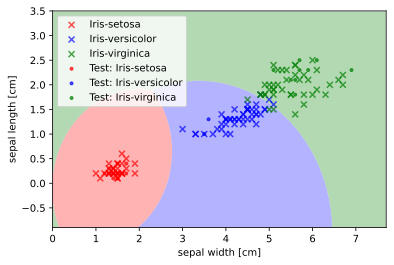

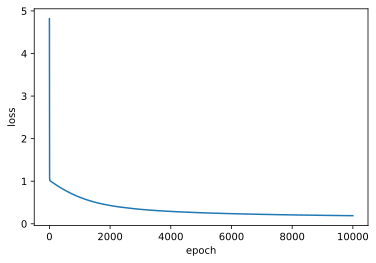

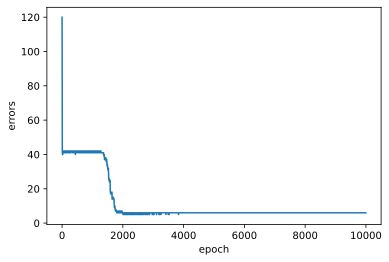

In [21]:
reset_initial_model_parameters()

model = NLSoftMaxAdaline(w, b, eta, phi)
loss_list, err_list = model.train(train_X, train_Y, 10000, 5, True)

plot_iris_decision_regions(model)

# plot the loss and errors

plt.subplots()

plt.plot(loss_list)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

plt.plot(err_list)
plt.xlabel('epoch')
plt.ylabel('errors')
plt.show()

### And an animation to observe the training

As said, since not only the shuffling but also the model parameters are random, let it run multiple times to observe different situations.

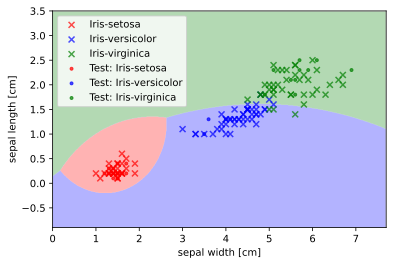

In [22]:
number_of_plots = 50
plot_after_epochs = 50

reset_initial_model_parameters()

model = NLSoftMaxAdaline(w, b, eta, phi)

fig, ax = plt.subplots()

loss_list = []
err_list = []
# plotting function per frame of the animation
def animate(i):
    global loss_list
    global err_list
    plt.cla()
    loss, errors = model.train(train_X, train_Y, plot_after_epochs, 5, verbose=False)
    loss_list += loss
    err_list += errors
    plot_iris_decision_regions(model)

# render the animation
anim = animation.FuncAnimation(fig, animate, number_of_plots)

# show the the animation in HTML
HTML(anim.to_html5_video())

### And plot the loss and errors per epoch

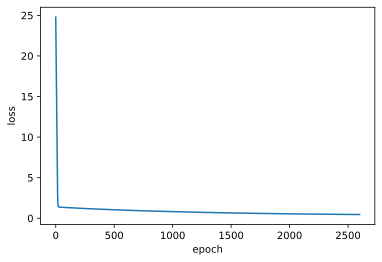

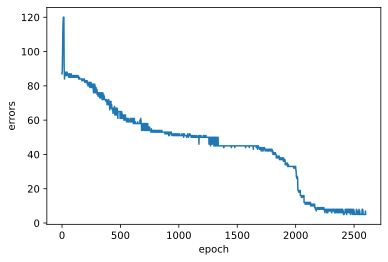

In [23]:
plt.subplots()

plt.plot(loss_list)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

plt.plot(err_list)
plt.xlabel('epoch')
plt.ylabel('errors')
plt.show()